In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import comb
from scipy.optimize import minimize
from IPython.display import display, Math

N = 1000
M = 1000
rng = np.random.default_rng()

%matplotlib inline


# Finding $Pr[\text{SS remains at home}]$


In [8]:
def prob_remains_home(n):
    return comb(2 * n, n) * (0.5 ** n) * (0.5 ** n)

In [9]:
ns = np.arange(1, N + 1)
ps = prob_remains_home(ns)

In [10]:
# fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

# sns.lineplot(x=ns, y=ps, ax=ax)
# ax.set_ylabel("Pr[SS ends up at home]")
# ax.set_xlabel("$n$")

# fig.savefig("graphics/02-endsathome", bbox_inches='tight')
# plt.show(fig)

# Finding $\mathbb E[\text{SS comes home}]$

In [11]:
def simulate_rd_walk_once(n):
    directions = rng.choice([-1, 1], n, replace=True)
    locations = np.cumsum(directions)
    return locations.size - np.count_nonzero(locations)

def simulate_rd_walk(max_n):
    sim_results = []
    for n in range(1, max_n + 1):
        new_results = [{"n": n, "Home visits": simulate_rd_walk_once(n), "Iteration": i} for i in range(M)]
        sim_results = sim_results + new_results
    return pd.DataFrame(sim_results)

In [12]:
df_probs = simulate_rd_walk(N)
df_probs.sample(10)

,n,Home visits,Iteration
504061,505,25,61
697877,698,0,877
932058,933,1,58
178689,179,0,689
501799,502,2,799
833707,834,43,707
984147,985,30,147
827748,828,7,748
380442,381,0,442
993842,994,26,842


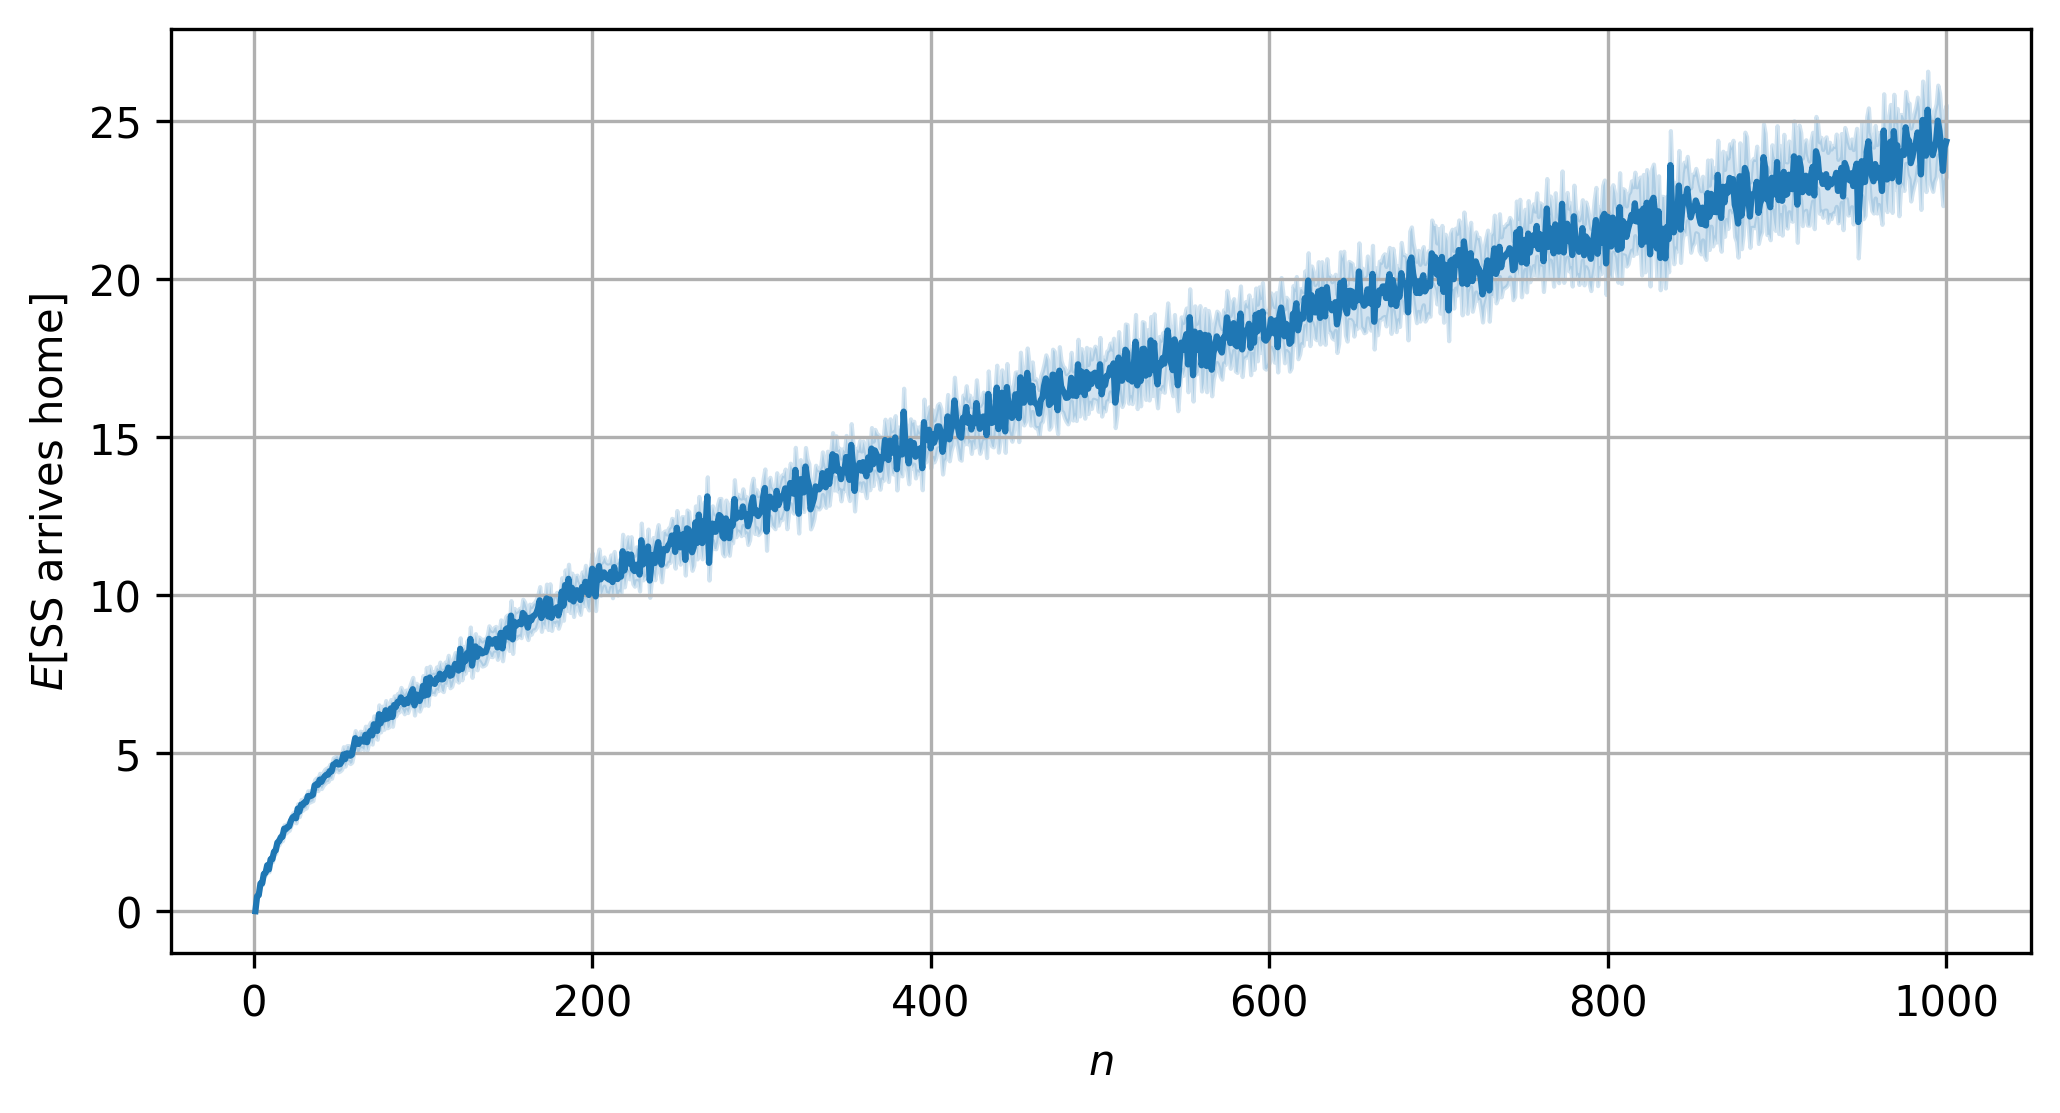

In [20]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

sns.lineplot(df_probs, x="n", y="Home visits")
ax.set_ylabel("$E$[SS arrives home]")
ax.set_xlabel("$n$")

fig.savefig("graphics/02-arriveshome", bbox_inches='tight')
ax.grid()
plt.show(fig)

In [21]:
s = 0

# xs = np.arange(1, N+1)[s:]
# ys = df_probs.groupby("n").mean()["Home visits"].to_numpy()[s:]
xs = df_probs["n"].to_numpy()[s:]
ys = df_probs["Home visits"].to_numpy()[s:]

In [22]:
def cost(v):
    a, b, h = v
    errors = (a + b * np.log(xs + h) - ys) ** 2
    return np.sum(errors)

minimize_res = minimize(cost, [0, 1, 1], bounds=[(None, None), (None, None), (0, None)])
k, r, h = minimize_res.x
minimize_res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 165635193.40791324
        x: [-6.900e+01  1.305e+01  2.298e+02]
      nit: 26
      jac: [-1.788e+01 -8.941e+00 -5.960e+00]
     nfev: 212
     njev: 53
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

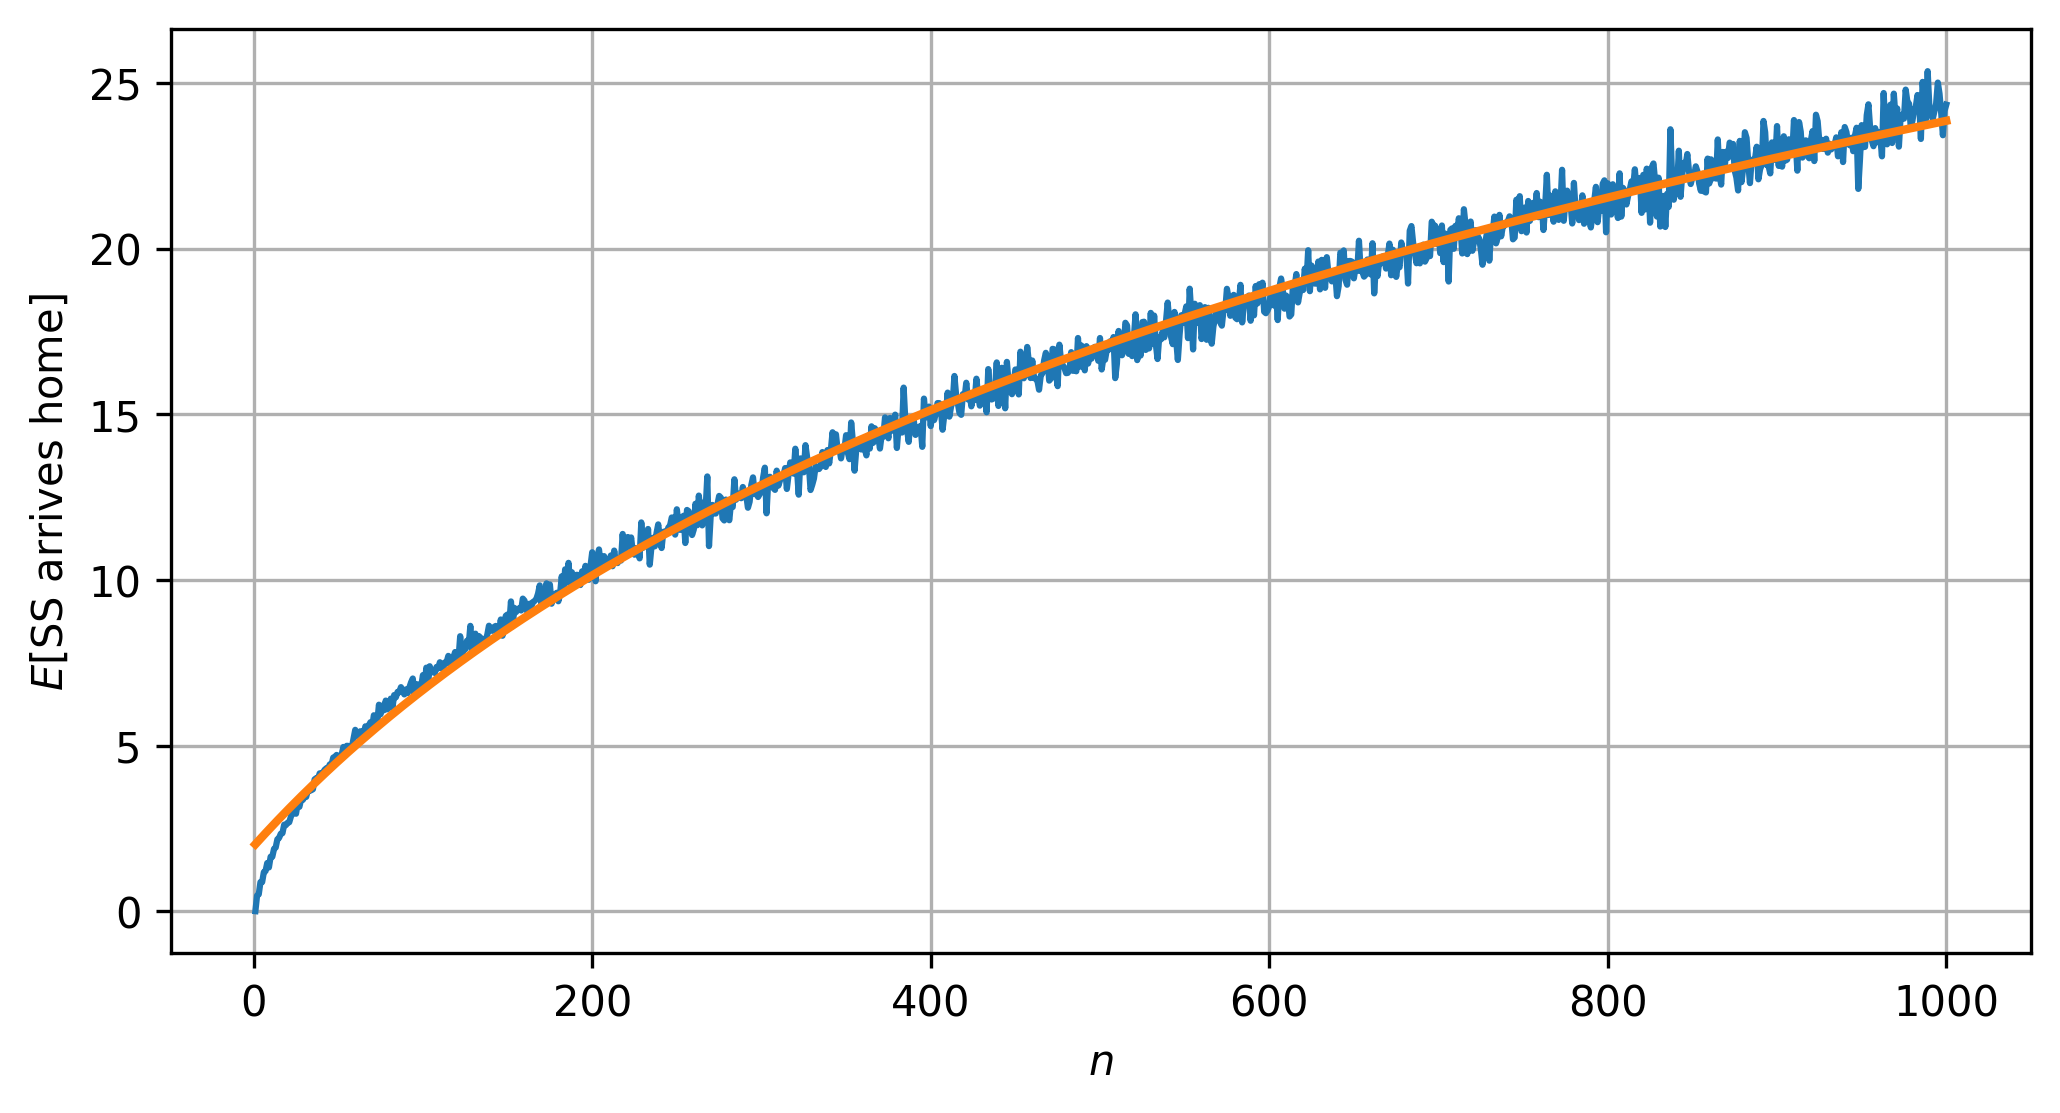

In [23]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

xs = np.arange(1, N+1)[s:]
ys = df_probs.groupby("n").mean()["Home visits"].to_numpy()[s:]

# sns.lineplot(df_probs, x="n", y="Home visits")
sns.lineplot(x=xs, y=ys)
ax.set_ylabel("$E$[SS arrives home]")
ax.set_xlabel("$n$")

# sns.lineplot(x=xs, y=a * np.log(xs) + b)
# sns.lineplot(x=xs, y=m * xs + c)
sns.lineplot(x=xs, y=r * np.log(xs + h) + k, linewidth=2)

fig.savefig("graphics/02-fittedline", bbox_inches='tight')
ax.grid()
plt.show(fig)

In [24]:
display(Math(f"\\text{{Best fit line }}r \\cdot \\log(x + h) + c \\approx {round(r, 2)}\\log(x + {round(h, 2)}) {round(k, 2)}"))

<IPython.core.display.Math object>

In [25]:
r, h, k

(13.050992900825626, 229.78717693307317, -68.99810021804116)